
### Maintenance dredging for accessibility purpose

This notebook aims to run a single run of dredging for a Trailing Suction Hopper Dredger when dredging is needed to keep the water depth in a desired value. For this purpose, the following picture shows the concept of accessibility.

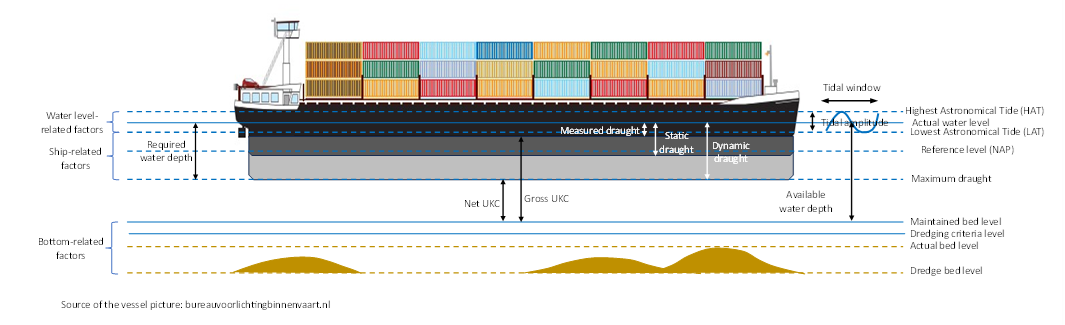

* When the actual water level is higher than the dredging criteria level due to sedimentation, dredging should be triggered and continued until the actual bed level reaches the dredging criteria level.
* Dredging criteria level depends on errors in surveys and uncertainties in dredging caused by different rates of sedimentation.
* The real-time data from the Port of Rotterdam are used to calculate the actual bed level.

The following variables are used to formulate the problem.
```
AWL: Actual (as in at this moment) Water Level (meters)
DCL: Dredge Criteria Level (DCL)
SR: Sedimentation Rate
```


#### 0. Import libraries

In [1]:
import datetime

import networkx as nx
import shapely
import shapely.geometry
import pyproj
import itertools


import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.core.access as access
import openclsim.model as model
import openclsim.plugins as plugin
import openclsim.plot as plot
import openclsim.plugins.access
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import folium

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
DredgedSite = type(
    "DredgedSite",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
        core.HasDredging,
    ),
    {},
)

Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.ContainerDependentMovable,
        core.HasResource,
        core.HasContainer,
        core.Processor,
        core.Identifiable,
        core.Log,
        core.LoadingFunction,
        core.UnloadingFunction,
        access.HasTide,
        # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata,
    ),
    {},
)

#### 3. Create objects

##### 3.1. Create site objects

In [4]:
# prepare input data for offshore
location_offshore = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
data_offshore = {
    "env": my_env,
    "name": "offshore",
    "geometry": location_offshore,
    "capacity": 100,
    "level": 0,
}
offshore = Site(**data_offshore)

# prepare input data for berth
location_berth = shapely.geometry.Point(4.062705498083785, 51.95909715255291)
data_berth = {
    "env": my_env,
    "name": "berth",
    "geometry": location_berth,
    "capacity": 100,
    "level": 80,
    "nr_resources": 1,
    # actual bed level is 0.5 above
    "ABL": -18,
    # dredging criterion level
    "DCL": -17.5,
    # dredge bed level (after dredging)
    "DBL": -18.5,
    # sedimentation rate of 1m per week, in m/s
    "SR": 1 / (3600 * 24 * 7)
    
}
berth = DredgedSite(**data_berth)

# prepare input data for dump
location_dump = shapely.geometry.Point(4.1795229742823, 52.11590591837503)
data_dump = {
    "env": my_env,
    "name": "dump",
    "geometry": location_dump,
    "capacity": 100,
    "level": 0,
}
dump = Site(**data_dump)

##### 3.2. Create vessel objects

In [5]:
# prepare input data for vessel_01 (dredging vessel)
data_vessel01 = {
    "env": my_env,
    "name": "dredging vessel",
    "geometry": location_dump,
    "capacity": 10,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 10 + 2 * x,
    "UKC": 0.3,
    "T": 5
}
# instantiate vessel_01
vessel01 = TransportProcessingResource(**data_vessel01)
assert not vessel01.metadata


# prepare input data for vessel_02 (seagoing vessel)
data_vessel02 = {
    "env": my_env,
    "name": "seagoing vessel",
    "geometry": location_offshore,
    "capacity": 10,
    "level": 5,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 15 + 2 * x,
    "UKC": 0.3,
    "T": 18
}
# instantiate vessel_02
vessel02 = TransportProcessingResource(**data_vessel02)
assert not vessel02.metadata

##### 3.3. Creat activity objects

In [6]:
# Initialise registry
registry = {}

In [7]:
# Define custom activities with Depth Plugin
# Here the order is important because HasDredge and HasTidePluginActivities are also MoveActivities
MoveWhenDredgingNeeded = type(
    "MoveWhenDredgingNeeded",
    (
        plugin.HasDredgePluginActivity,
        plugin.HasTidePluginActivity,
        model.MoveActivity,
    ),
    {},
)

MoveWhenTideAllows = type(
    "MoveWhenTideAllows",
    (
        plugin.HasTidePluginActivity,
        model.MoveActivity,
    ),
    {},
)

switch [False False False ... False False False]
switch [False False False ... False False False]


1410.0

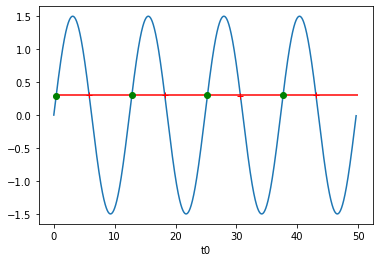

In [8]:

# env.now
t_now = 0
t_hours = t_now / 3600.0
# time to look ahead in the future for tidal windows (2 days ahead)
t_max = 12.42 * 4
threshold = 0.3000000000000007




    

tidal_windows_df = openclsim.plugins.access.compute_tidal_windows(openclsim.plugins.access.water_level, t_now, t_max, threshold)

    

fig, ax = plt.subplots()

t = np.arange(t_now, t_max, 1 / 60)
water_levels =  openclsim.plugins.access.water_level(t)

ax.plot(t,  water_levels)
tidal_windows_df[tidal_windows_df.tide_allows].plot('t1', 'water_level_t1', style='r+', ax=ax, legend=False)
ax.hlines([threshold], 0, 50, colors='red')
tidal_windows_df[tidal_windows_df.tide_allows].plot('t0', 'water_level_t0', style='go', ax=ax, legend=False)


tidal_windows_df = openclsim.plugins.access.compute_tidal_windows(openclsim.plugins.access.water_level, my_env.now * 3600, t_max, threshold)
selected_windows = tidal_windows_df[tidal_windows_df.tide_allows]
selected_window = selected_windows.iloc[0]
time_to_start_sailing = (selected_window.t0 * 3600)
delay = time_to_start_sailing - my_env.now
delay

In [9]:
# Specify the amount of container and duration of activities
amount = 10
duration = 200


dredge_criteria = plugin.DredgeCriterion(
    name="dredge_crit",
)

tide_criteria = plugin.TideCriterion(
    name="tide_crit",
)

# Specify dredging subprocesses
dredging_subprocesses = [
    MoveWhenDredgingNeeded(
        env=my_env,
        name="sailing empty dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=berth,
        dredge_criteria=dredge_criteria,
        tide_criteria=tide_criteria,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="loading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=berth,
        destination=vessel01,
        amount=amount,
        duration=50 * amount,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing full dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=dump,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=dump,
        amount=amount,
        duration=20 * amount,
    ),
]

# Define activities of the dredging vessel
activities_dredging_vessel = model.WhileActivity(
    env=my_env,
    name="while sequential activity dredging vessel",
    registry=registry,
    sub_processes=[
        model.SequentialActivity(
            env=my_env,
            name=f"sequential activity subcycle dredging vessel",
            registry=registry,
            sub_processes=dredging_subprocesses,
        )
    ],
    condition_event=[
        {
            "type": "container",
            "concept": berth,
            "state": "empty",
            "id_": "default_reservations",
        }
    ],
)

In [10]:
# Specify seagoing subprocesses
requested_resources = {}

dredge_criteria = plugin.DredgeCriterion(
    name="dredge_crit",
)

tide_criteria = plugin.TideCriterion(
    name="tide_crit",
)

seagoing_subprocesses = [
    model.BasicActivity(
        env=my_env, name="interval time", registry=registry, duration=200
    ),
    MoveWhenTideAllows(
        env=my_env,
        name="sailing full seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=berth,
        tide_criteria=tide_criteria,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading seagoing vessel",
        registry=registry,
        processor=vessel02,
        origin=vessel02,
        destination=berth,
        amount=amount,
        duration=30 * amount,
        requested_resources=requested_resources,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing empty seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=offshore,
    ),
]

# Define activities of the seagoing vessel
activities_seagoing_vessel = model.WhileActivity(
    env=my_env,
    name="while sequential activity dredging vessel",
    registry=registry,
    sub_processes=seagoing_subprocesses,
    condition_event=[
        {
            "type": "container",
            "concept": vessel02,
            "state": "empty",
            "id_": "default_reservations",
        }
    ],
)

#### 4. Register activities and run simpy

In [11]:
# register dredging activities
# model.register_processes([activities_dredging_vessel])

# register seagoing activities
model.register_processes([activities_seagoing_vessel])

In [12]:
my_env.run()

mover seagoing vessel destination berth
check tidal criteria 200
wait until we tidal window allows to sail
threshold 0.3000000000000007 ABL -18 UKC 0.3 T 18
switch [False False False ... False False False]
waiting for 1229.9999999999998 seconds
activity log <__main__.MoveWhenTideAllows object at 0x147694280>
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover seagoing vessel destination offshore
updating to destination geometry POINT (3.637610458072877 52.10701582514347)


In [13]:
# the seagoing log is now not in the ship but in the plugin....
seagoing_cycle_log_df = pd.DataFrame(activities_seagoing_vessel.sub_processes[1].logbook)
seagoing_cycle_log_df

name_by_id = {key: list(obj)[0].name for (key, obj) in registry['id'].items()}
name_by_id

seagoing_cycle_log_df.merge(pd.DataFrame(pd.Series(name_by_id), columns=['name']), left_on='ActivityID', right_index=True)


,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel,name
0,1970-01-01 00:03:20.000000,d0ea830b-a2ea-46ad-bcc8-aee8ae6968b2,WAIT_START,{},"{'type': 'plugin', 'ref': 'tide'}",sailing full seagoing vessel
1,1970-01-01 00:23:50.000000,d0ea830b-a2ea-46ad-bcc8-aee8ae6968b2,WAIT_STOP,{},"{'type': 'plugin', 'ref': 'tide'}",sailing full seagoing vessel
2,1970-01-01 00:23:50.000000,d0ea830b-a2ea-46ad-bcc8-aee8ae6968b2,START,{},{},sailing full seagoing vessel
3,1970-01-01 00:58:43.474629,d0ea830b-a2ea-46ad-bcc8-aee8ae6968b2,STOP,{},{},sailing full seagoing vessel


In [14]:
# the dredging log is now not in the ship but in the plugin....
dredging_cycle_log_df = pd.DataFrame(activities_dredging_vessel.sub_processes[0].sub_processes[0].logbook)
dredging_cycle_log_df

""


#### 5. Inspect results

##### 5.1. Inspect logs

In [15]:
# Inspect dredging vessel log
display(plot.get_log_dataframe(vessel01, [activities_dredging_vessel]))

,Activity,Timestamp,ActivityState


In [16]:
# Inspect seagoing vessel log
display(plot.get_log_dataframe(vessel02, [activities_seagoing_vessel]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing full seagoing vessel,1970-01-01 00:23:50.000000,START,POINT (3.637610458072877 52.10701582514347),5
1,sailing full seagoing vessel,1970-01-01 00:58:43.474629,STOP,POINT (4.062705498083785 51.95909715255291),5
2,unloading seagoing vessel,1970-01-01 00:58:43.474629,START,POINT (4.062705498083785 51.95909715255291),5
3,unloading seagoing vessel,1970-01-01 01:03:43.474629,STOP,POINT (4.062705498083785 51.95909715255291),0
4,sailing empty seagoing vessel,1970-01-01 01:03:43.474629,START,POINT (4.062705498083785 51.95909715255291),0
5,sailing empty seagoing vessel,1970-01-01 01:40:56.514232,STOP,POINT (3.637610458072877 52.10701582514347),0
